# **Lab4 : Function Approximation**
**Sanskar Gupta**

# **Abstract**
This notebook  cover function approximations.Here function approximation using L2 norms will be implemented over a given 1D mesh.


#**About the code**

In [120]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Sanskar Gupta (sanskar@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

#**Environment Setup**

In [121]:
import numpy as np
import unittest
import math
import matplotlib.pyplot as plt
from matplotlib import tri
plt.style.use('classic')
import scipy.integrate as integrate
from scipy.integrate import quad, dblquad
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

#**Introduction**
We come across functions that possess high computational costs, there are methods developed that can reduce the computational cost by generating approximate functions which will be demonstrated in this notebook.

#**Methods**

##**L2 projection in one dimension**

The L2 projection of a function on a space of linear functions
$
\displaystyle
P_h f(x) = \sum_{j=0}^{m+1} \alpha_j\phi_j(x)
$

according to the equation 9.13 in the lecture notes.
This leaves us with the matrix equation 
$
A\alpha = b
$, 
where $alpha$ is the solution vector, and A i a diagonal matrix with $a_{i,i} = \frac{h_i}{3} + \frac{h_{i+1}}{3}$, $a_{i,i+1} = \frac{h_{i+1}}{6}$, and $a_{i,i-1} = \frac{h_i}{6}$, and $h_i$ is the length of the i:th mesh element.

$b_i$ is evaluated as the integral $\int_I f(x)\phi_i(x)dx$ according to the equation 9.15 in lecture notes

$b_i = f(x_i)(\frac{h_i}{2} + \frac{h_{i+1}}{2})$



In [122]:
def assembleSystem(function, mesh):
  n = mesh.shape[0]
  A = np.zeros(shape=(n,n))
  b = np.zeros(n)

  # A matrix
  for i in range(0, n):

    if i > 0:
      hi = mesh[i]-mesh[i-1]
      A[i,i] += hi/3
      A[i,i-1] = hi/6

    if i < n-1: 
      hi1 = mesh[i+1]-mesh[i]
      A[i,i] += hi1/3
      A[i,i+1] = hi1/6

  # b vector
  for i in range(0, n):
    if i > 0:
      hi = mesh[i] - mesh[i-1]
      b[i] += function(mesh[i])*hi/2
    if i < n-1:
      hi1 = mesh[i+1] - mesh[i]
      b[i] += function(mesh[i])*hi1/2

  return A, b   

In [123]:
def solveForAlpha(function, mesh):
  A,b=assembleSystem(function, mesh)
  return np.linalg.solve(A,b)

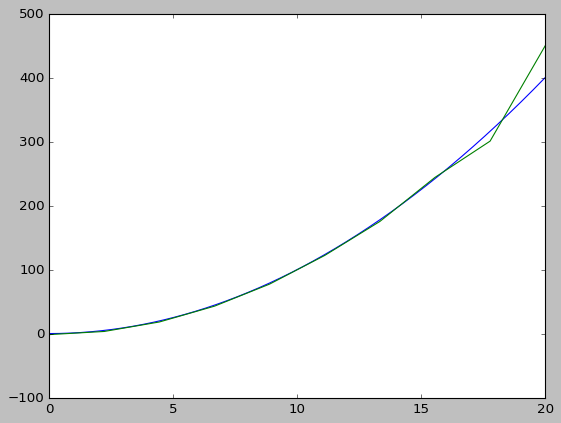

In [124]:
x = np.linspace(0,20,1000)
mesh = np.linspace(0, 20, 10)
function = lambda x: x**2
alphas = solveForAlpha(function, mesh)

plt.plot(x, function(x))
plt.plot(mesh, alphas)

plt.show()

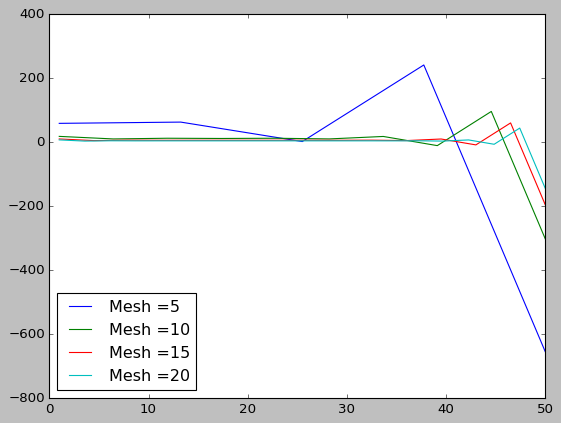

In [125]:

test_mesh_sizes = [5 ,10 ,15,20]
for i in range(len(test_mesh_sizes)):
  test_mesh = np.linspace(1, 50, test_mesh_sizes[i])
  function = lambda x:x**2  
  alphas = solveForAlpha(function, test_mesh)
  mapped = map(function, test_mesh) 
  plt.plot(test_mesh, function(test_mesh) - alphas, label='Mesh =' + str(test_mesh_sizes[i])) 
  plt.legend(loc='lower left')

plt.show()

##**Observations**
It was observed that the error i.e difference between the approximated value and the real function value decreases on increasing mesh size

#**L2 Projection in 2 Dimensions**

This method  function and a 2D triangular mesh data structure

The algorithm iterates through every triangle $i$, and constructs an upper triangular $LA \in \mathbb{R}^{3 \times 3}$. This local array is obtained from considering the entries of the global array that involve non-zero areas in the triangle

The array p contains the coordinates of right angled triangle while the array t contains the indices i.e which coordinates to pick up while forming the trinagle.
https://stackoverflow.com/questions/45243563/creating-a-triangulation-for-use-in-matplotlibs-plot-trisurf-with-matplotlib-tr

$\left ( \begin{array}{ccc} \langle \phi_0, \phi_0 \rangle & \langle \phi_0, \phi_1 \rangle & \langle \phi_0, \phi_2 \\ \langle \phi_1, \phi_0 \rangle & \langle \phi_1, \phi_1 \rangle & \langle \phi_1, \phi_2 \rangle \\ \langle \phi_2, \phi_0 \rangle & \langle \phi_2, \phi_1 \rangle & \langle \phi_2, \phi_2 \rangle \end{array} \right )$

, where $\phi_0 = \lambda_{i, 1}$, $\phi_1 = \lambda_{i, 2}$ and $\phi_2 = \lambda_{i, 3}$. In a way analogous to the construction of the local matrix in the 1D case, this yields (along with the exact formulas obtained from the lecture notes):

$M = \left ( \begin{array}{ccc} A_i/6 & A_i/12 & A_i/12 \\ 0 & A_i/6 & A_i/12 \\ 0 & 0 & A_i/6 \end{array} \right )$

The algorithm then fills in the global matrix $A$ in blocks of size $3 \times 3$, and the $3$ relevant entries in the global vector $b$ (i. e., $\int_{T_i} f\phi_j$, $0 \leq j < 3$) are calculated using right triangle area.

The resulting system $A\alpha = b$ is solved for $\alpha$




In [130]:
def getRightTriangleMesh():
    p = np.array([
        [-1,-0.5,0,0.5,1,-1,-0.5,0,0.5,1,-1,-0.5,0,0.5,1,-1,-0.5,0,0.5,1,-1,-0.5,0,0.5,1],    #x and y coordinates
        [-1,-1,-1,-1,-1,-0.5,-0.5,-0.5,-0.5,-0.5,0,0,0,0,0,0.5,0.5,0.5,0.5,0.5,1,1,1,1,1]
        ])
    t = np.array([            #indices (3 rows as triangles have 3 nodes)
        [1,2,2,2,3,4,4,4,
         6,6,12,12,13,14,14,14,
         11,17,17,13,13,19,19,15,
         16,16,17,18,18,18,19,20
         ],
        
        [2,7,8,3,4,9,9,5,
         11,12,7,7,8,8,9,15,
         12,12,12,12,14,14,14,14,
         21,17,18,22,23,19,20,24
         ],
        
        [6,6,7,8,8,8,10,10,
         12,7,8,13,14,9,10,10,
         16,16,18,18,18,18,20,20,
         22,22,22,23,24,24,24,25
         ]
        ])
    return p,t

In [127]:
def triangleArea(x, y):
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))


# This function to evaluate the Mass Matrix
def getMassMatrix(p, t):
    nNodes = p.shape[1]  # number of nodes
    nElements = t.shape[1]  # number of elements

    M = np.zeros((nNodes, nNodes))  # initialize the Mass Matrix

    for k in range(nElements):
        loc2glob = t[0:3, k] - 1
        x = p[0, loc2glob]
        y = p[1, loc2glob]
        area = triangleArea(x, y)
        M_k = np.array(([2, 1, 1], [1, 2, 1], [1, 1, 2])) / 12 * area
        M[np.ix_(loc2glob, loc2glob)] += M_k  # creating the global matrix
    return M


def getFunction(x, y):
    return np.sin(x) + np.sin(y)


# This laod vector function evaluation.
def getLoadVector(p, t):
    nNodes = p.shape[1]
    nElements = t.shape[1]

    b = np.zeros((nNodes, 1))

    for k in range(nElements):
        loc2glob = t[0:3, k] - 1
        x = p[0, loc2glob]
        y = p[1, loc2glob]
        area = triangleArea(x, y)
        bk = np.array(([getFunction(x[0], y[0])],
                       [getFunction(x[1], y[1])],
                       [getFunction(x[2], y[2])])) / 3 * area
        b[loc2glob] += bk

    return b

In [131]:
p,t=getRightTriangleMesh()
print(t.shape)

(3, 32)


In [128]:
def test2DProjection():
  p,t=getRightTriangleMesh()
  massMatrix= getMassMatrix(p,t)
  loadVector = getLoadVector(p,t)
  alphas =  np.linalg.inv(M)@b
  x = p[0,:]
  y = p[1,:]
  result = np.zeros(len(alphas))

  for i in range(len(alphas)):
      result[i] = alphas[i][0]
  error=result-(np.sin(x)+np.sin(y))
  print(error)
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  z =result
  surf = ax.plot_trisurf(x, y, z, cmap=cm.Spectral,linewidth=0, antialiased=False)
  ax.zaxis.set_major_locator(LinearLocator(10))
  ax.zaxis.set_major_formatter(FormatStrFormatter('  %.03f'))
  fig.colorbar(surf, shrink=0.7, aspect=9)
  plt.title('$L^2$ projection of f(x)')
  plt.show() 

[-0.54516398 -0.45445137 -0.30337206 -0.67208457  0.00166459 -0.44754368
 -0.1792677   0.17385058 -0.01711658  0.66875538 -0.29346087  0.14817193
  0.07367473 -0.10205508  0.25821005 -0.66727973 -0.01201409 -0.09839443
 -0.05604503  0.49483757  0.00086057  0.6655586   0.25745241  0.49374363
  0.50187091]


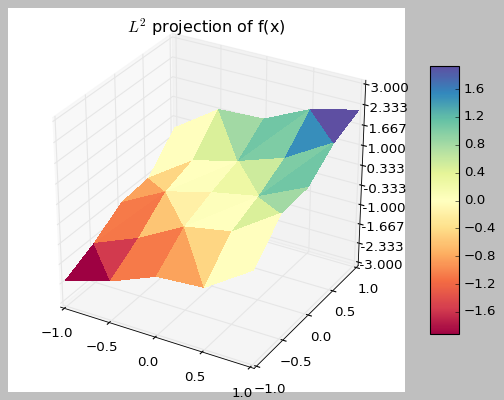

In [129]:
test2DProjection()

##**Results**
The function sin(x) + sin(y) was approximated using a right triangle mesh with the errors shown above
